# How to train a new language model from scratch using Transformers and Tokenizers

Copyright 2023-24, Denis Rothman. Denis Rothman adapted a Hugging Face reference notebook to pretrain a transformer model.

In **October 2024**, wandb.ai training metrics were added while training. You can now view your model's metrics on Hugging Face.  
In 2023, a hardware accelerator was added.

It is recommended to understand this notebook. The emergence of GPT-3 engines has produced an API that can outperform many trained transformers models. However, to show a transformer what to do with the input datasets, it is essential to understand how they are trained.

The Transformer model of this notebook is a Transformer model named ***KantaiBERT***. ***KantaiBERT*** is trained as a RoBERTa Transformer with DistilBERT architecture. The dataset was compiled from three books by Immanuel Kant downloaded from the [Gutenberg Project](https://www.gutenberg.org/).


***KantaiBERT*** was pretrained with a small model of 84 million parameters using the same number of layers and heads as DistilBert, i.e., 6 layers, 768 hidden size,and 12 attention heads. ***KantaiBERT*** is then fine-tuned for a downstream masked Language Modeling task.

### The Hugging Face original Reference and notes:

Notebook edition (link to original of the reference blogpost [link](https://huggingface.co/blog/how-to-train)).


#Step 1: Loading the dataset

In [1]:
from IPython.display import Image     #This is used for rendering images in the notebook

In [2]:
import requests
from PIL import Image
from io import BytesIO

def get_image_from_github(image_name):

    # The base URL of the image files in the GitHub repository
    base_url = 'https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/main/Notebook%20images/06/'

    # Make the request
    response = requests.get(base_url + image_name)

    # Check if the request was successful
    if response.status_code == 200:
        # Read the image
        image = Image.open(BytesIO(response.content))

        # Return the image
        return image
    else:
        print(f'Error {response.status_code}: Could not access the image file.')
        return None

In [3]:
#1.Load kant.txt using the Colab file manager
#2.Downloading the file from GitHub
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/master/Chapter06/kant.txt --output "kant.txt"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.7M  100 10.7M    0     0  55.2M      0 --:--:-- --:--:-- --:--:-- 55.3M


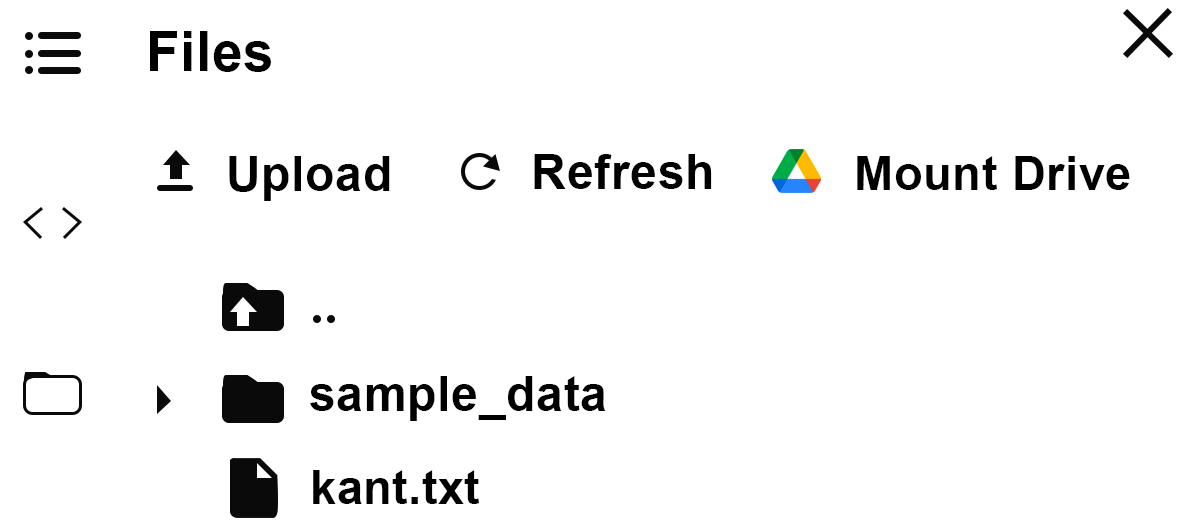

In [4]:
display(get_image_from_github('B19899_06_01.png') or print('Image not found'))

#Step 2: Installing Hugging Face transformers

April 2023 update From Hugging Face Issue 22816:

https://github.com/huggingface/transformers/issues/22816

"The PartialState import was added as a dependency on the transformers development branch yesterday. PartialState was added in the 0.17.0 release in accelerate, and so for the development branch of transformers, accelerate >= 0.17.0 is required.

Downgrading the transformers version removes the code which is importing PartialState."

Denis Rothman: The following cell imports the latest version of Hugging Face transformers but without downgrading it.

To adapt to the Hugging Face upgrade, A GPU accelerator was activated using the Google Colab Pro with the following NVIDIA GPU:
GPU Name: NVIDIA A100-SXM4-40GB

In [5]:
!pip install Transformers==4.46.1
!pip install accelerate==1.0.1
#!pip install --upgrade accelerate
from accelerate import Accelerator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 115.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 77.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: Transformers
    Found existing installation: transformers 4.48.3
    Uninstalling transformers-4.48.3:
      Successfully uninstalled transformers-4.48.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━

#Step 3: Training a tokenizer

In [6]:
from pathlib import Path

from tokenizers import ByteLevelBPETokenizer

paths = [str(x) for x in Path(".").glob("**/*.txt")]

# Read the content from the files, ignoring or replacing invalid characters
file_contents = []
for path in paths:
    try:
        with open(path, 'r', encoding='utf-8', errors='replace') as file:
            file_contents.append(file.read())
    except Exception as e:
        print(f"Error reading {path}: {e}")

# Join the contents into a single string
text = "\n".join(file_contents)

# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer()

# Customize training
tokenizer.train_from_iterator([text], vocab_size=52_000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

#Step 4: Saving the files to disk

In [7]:
import os
token_dir = '/content/KantaiBERT'
if not os.path.exists(token_dir):
  os.makedirs(token_dir)
tokenizer.save_model('KantaiBERT')

['KantaiBERT/vocab.json', 'KantaiBERT/merges.txt']

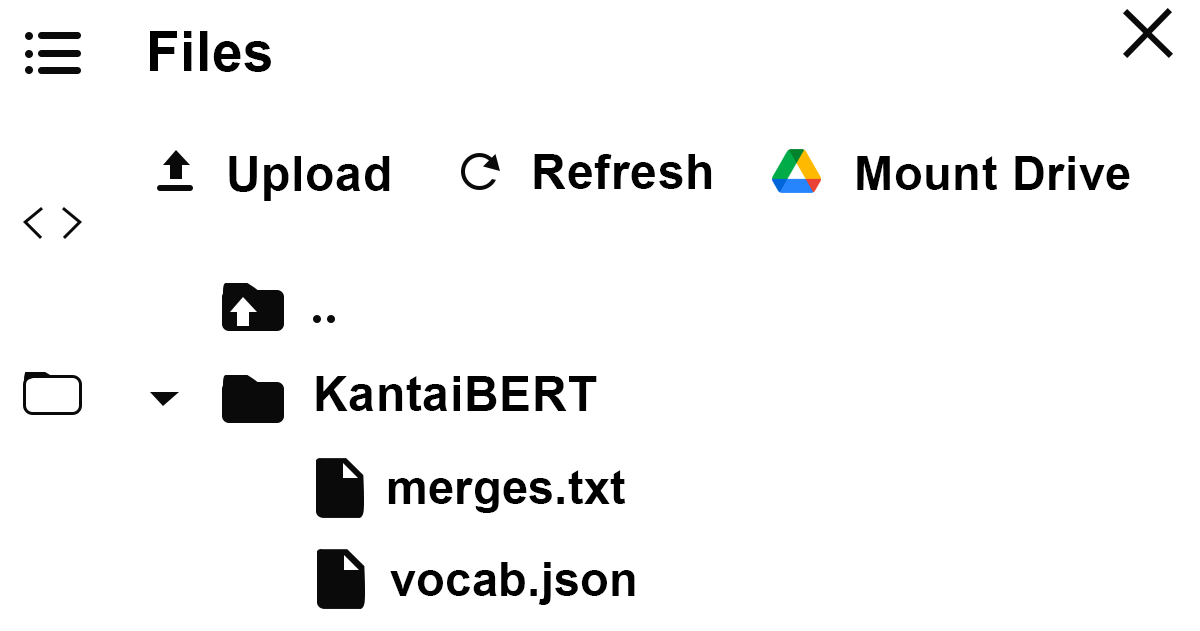

In [8]:
display(get_image_from_github('B19899_06_02.png') or print('Image not found'))

#Step 5: Loading the trained tokenizer files

In [9]:
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

tokenizer = ByteLevelBPETokenizer(
    "./KantaiBERT/vocab.json",
    "./KantaiBERT/merges.txt",
)

In [10]:
tokenizer.encode("The Critique of Pure Reason.").tokens

['The', 'ĠCritique', 'Ġof', 'ĠPure', 'ĠReason', '.']

In [11]:
tokenizer.encode("The Critique of Pure Reason.")

Encoding(num_tokens=6, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [12]:
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)
tokenizer.enable_truncation(max_length=512)

#Step 6: Checking Resource Constraints: GPU and NVIDIA

In [13]:
!nvidia-smi

Wed Mar 12 06:11:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             46W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [14]:
#@title Checking that PyTorch Sees CUDA
import torch
torch.cuda.is_available()

True

#Step 7: Defining the configuration of the model

In [15]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=52_000,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)

In [ ]:
print(config)

#Step 8: Reloading the tokenizer in transformers

In [16]:
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained("./KantaiBERT", max_length=512)

#Step 9: Initializing a model from scratch

In [17]:
from transformers import RobertaForMaskedLM

model = RobertaForMaskedLM(config=config)
print(model)

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm)

## Exploring the parameters

In [18]:
print(model.num_parameters())

83504416


In [19]:
LP=list(model.parameters())
lp=len(LP)
print(lp)
for p in range(0,lp):
  print(LP[p])

106
Parameter containing:
tensor([[-0.0151, -0.0093, -0.0122,  ..., -0.0032, -0.0148,  0.0132],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0018,  0.0164,  0.0262,  ...,  0.0021,  0.0292, -0.0273],
        ...,
        [-0.0302,  0.0120, -0.0257,  ..., -0.0005, -0.0131, -0.0087],
        [-0.0035, -0.0292,  0.0037,  ...,  0.0009, -0.0076, -0.0320],
        [-0.0021,  0.0467, -0.0027,  ...,  0.0198,  0.0321, -0.0020]],
       requires_grad=True)
Parameter containing:
tensor([[ 0.0226, -0.0259,  0.0215,  ...,  0.0105,  0.0241,  0.0167],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0007, -0.0059,  0.0153,  ...,  0.0081,  0.0101, -0.0100],
        ...,
        [ 0.0151,  0.0151,  0.0224,  ...,  0.0122, -0.0067, -0.0097],
        [ 0.0229,  0.0090,  0.0202,  ..., -0.0122,  0.0109, -0.0074],
        [ 0.0018,  0.0275,  0.0393,  ..., -0.0142,  0.0066, -0.0217]],
       requires_grad=True)
Parameter containing:
tensor([

In [20]:
#Shape of each tensor in the model
LP = list(model.parameters())
for i, tensor in enumerate(LP):
    print(f"Shape of tensor {i}: {tensor.shape}")

Shape of tensor 0: torch.Size([52000, 768])
Shape of tensor 1: torch.Size([514, 768])
Shape of tensor 2: torch.Size([1, 768])
Shape of tensor 3: torch.Size([768])
Shape of tensor 4: torch.Size([768])
Shape of tensor 5: torch.Size([768, 768])
Shape of tensor 6: torch.Size([768])
Shape of tensor 7: torch.Size([768, 768])
Shape of tensor 8: torch.Size([768])
Shape of tensor 9: torch.Size([768, 768])
Shape of tensor 10: torch.Size([768])
Shape of tensor 11: torch.Size([768, 768])
Shape of tensor 12: torch.Size([768])
Shape of tensor 13: torch.Size([768])
Shape of tensor 14: torch.Size([768])
Shape of tensor 15: torch.Size([3072, 768])
Shape of tensor 16: torch.Size([3072])
Shape of tensor 17: torch.Size([768, 3072])
Shape of tensor 18: torch.Size([768])
Shape of tensor 19: torch.Size([768])
Shape of tensor 20: torch.Size([768])
Shape of tensor 21: torch.Size([768, 768])
Shape of tensor 22: torch.Size([768])
Shape of tensor 23: torch.Size([768, 768])
Shape of tensor 24: torch.Size([768])
Sh

In [21]:
#counting the parameters
np=0
for p in range(0,lp):#number of tensors
  PL2=True
  try:
    L2=len(LP[p][0]) #check if 2D
  except:
    L2=1             #not 2D but 1D
    PL2=False
  L1=len(LP[p])
  L3=L1*L2
  np+=L3             # number of parameters per tensor
  if PL2==True:
    print(p,L1,L2,L3)  # displaying the sizes of the parameters
  if PL2==False:
    print(p,L1,L3)  # displaying the sizes of the parameters

print(np)              # total number of parameters

0 52000 768 39936000
1 514 768 394752
2 1 768 768
3 768 768
4 768 768
5 768 768 589824
6 768 768
7 768 768 589824
8 768 768
9 768 768 589824
10 768 768
11 768 768 589824
12 768 768
13 768 768
14 768 768
15 3072 768 2359296
16 3072 3072
17 768 3072 2359296
18 768 768
19 768 768
20 768 768
21 768 768 589824
22 768 768
23 768 768 589824
24 768 768
25 768 768 589824
26 768 768
27 768 768 589824
28 768 768
29 768 768
30 768 768
31 3072 768 2359296
32 3072 3072
33 768 3072 2359296
34 768 768
35 768 768
36 768 768
37 768 768 589824
38 768 768
39 768 768 589824
40 768 768
41 768 768 589824
42 768 768
43 768 768 589824
44 768 768
45 768 768
46 768 768
47 3072 768 2359296
48 3072 3072
49 768 3072 2359296
50 768 768
51 768 768
52 768 768
53 768 768 589824
54 768 768
55 768 768 589824
56 768 768
57 768 768 589824
58 768 768
59 768 768 589824
60 768 768
61 768 768
62 768 768
63 3072 768 2359296
64 3072 3072
65 768 3072 2359296
66 768 768
67 768 768
68 768 768
69 768 768 589824
70 768 768
71 768 768

#Step 10: Building the dataset

In [22]:
%%time
from transformers import LineByLineTextDataset

dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="./kant.txt",
    block_size=128,
)

/usr/local/lib/python3.11/dist-packages/transformers/data/datasets/language_modeling.py:119: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


CPU times: user 17.5 s, sys: 226 ms, total: 17.7 s
Wall time: 17.7 s


#Step 11: Defining a data collator

In [23]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

#Step 12: Initializing the trainer

In [24]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./KantaiBERT",
    overwrite_output_dir=True,
    num_train_epochs=1, #can be increased
    per_device_train_batch_size=64,
    save_steps=10_000,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

#Step 13: Pretraining the model

In [25]:
%%time
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: denis-rothman76 (rothman) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,6.575900
1000,5.689600
1500,5.221000
2000,4.993300
2500,4.890800


CPU times: user 2min 31s, sys: 2.11 s, total: 2min 33s
Wall time: 2min 57s


TrainOutput(global_step=2672, training_loss=5.432427503391654, metrics={'train_runtime': 177.5557, 'train_samples_per_second': 962.875, 'train_steps_per_second': 15.049, 'total_flos': 873691623267840.0, 'train_loss': 5.432427503391654, 'epoch': 1.0})

#Step 14: Saving the final model (+tokenizer + config) to disk

In [26]:
trainer.save_model("./KantaiBERT")

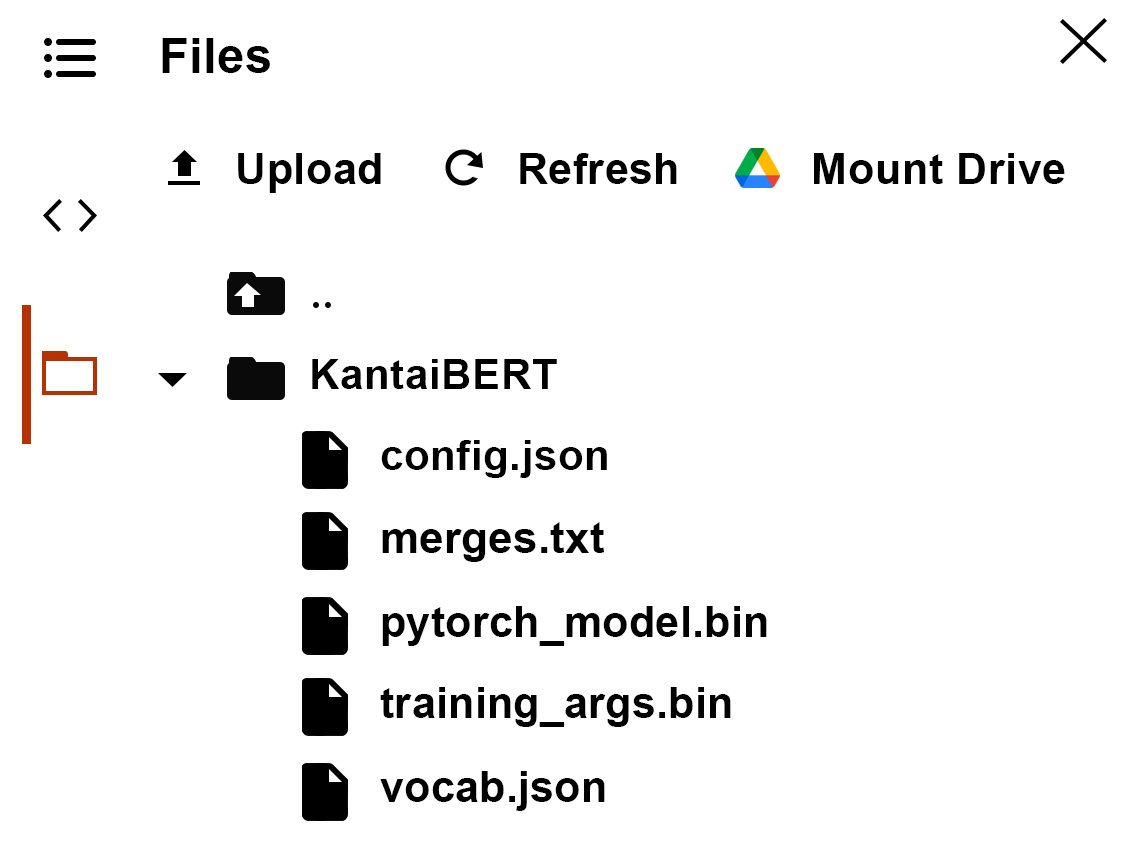

In [27]:
display(get_image_from_github('B19899_06_05.png') or print('Image not found'))

#Step 15: Language modeling with FillMaskPipeline

In [28]:
from transformers import pipeline

fill_mask = pipeline(
    "fill-mask",
    model="./KantaiBERT",
    tokenizer="./KantaiBERT"
)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [29]:
fill_mask("Human thinking involves human <mask>.")

[{'score': 0.018276121467351913,
  'token': 393,
  'token_str': ' reason',
  'sequence': 'Human thinking involves human reason.'},
 {'score': 0.011303701438009739,
  'token': 532,
  'token_str': ' experience',
  'sequence': 'Human thinking involves human experience.'},
 {'score': 0.010611210949718952,
  'token': 446,
  'token_str': ' law',
  'sequence': 'Human thinking involves human law.'},
 {'score': 0.009849428199231625,
  'token': 582,
  'token_str': ' intuition',
  'sequence': 'Human thinking involves human intuition.'},
 {'score': 0.009582584723830223,
  'token': 606,
  'token_str': ' conceptions',
  'sequence': 'Human thinking involves human conceptions.'}]